In [41]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.feature_selection import RFE

from sklearn.feature_selection import mutual_info_regression


# Fáza 2 - Predspracovanie údajov

## 2.1 Realizácia predspracovania dát

### A - Rozdelenia dát na trénovaciu a testovaciu množinu

#### zlúčime potrebné dáta do jedného datasetu 

In [43]:
# loading datasets
df_processes    = pd.read_csv("processes.csv", sep='\t')
df_connections  = pd.read_csv("connections.csv", sep='\t')

#### vyberieme si dáta, ktoré sme identifikovali v EDA

In [44]:
df_processes    = df_processes[["imei", "ts", "mwra", "p.android.gm", "p.android.documentsui", "p.system", "p.android.externalstorage", "p.android.settings", "p.android.chrome"]]
df_connections  = df_connections[["imei", "ts", "mwra", "c.katana", "c.dogalize", "c.android.chrome", "c.android.gm"]]

#### spojíme ich pomocou "ts" a "imei"

In [45]:
df = df_connections.merge(df_processes, on=['imei', 'ts'], how='outer')

#### Rozdelíme dáta v pomere 80:20 (trénovacia/testovacia množina). Tento pomer vychádza z predpokladu, že pri dostatočne veľkom množstve dát, máme pri rozdelení dostatok dát na trénovanie a efektívne učenie modelu, zatiaľ čo testovacia množina bude dostatočne veľká pre overenie modelu. Tento pomer je bežný a vhodný pre väčšinu úloh strojového učenia.

In [46]:
TRAIN = 0.8

train_df, test_df = train_test_split(df, train_size=TRAIN, random_state=42)

train_df.head()

,imei,ts,mwra_x,c.katana,c.dogalize,c.android.chrome,c.android.gm,mwra_y,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,863033069630348354,2018-05-07 06:23:00,1.0,8.78526,12.97475,11.62351,14.41864,1.0,9.23972,10.43492,13.82551,9.86109,8.95921,11.39909
12572,8630330696303481545,2018-05-11 14:57:00,1.0,11.81607,14.66263,10.73155,14.21554,1.0,10.37842,10.42450,14.23429,14.15057,9.07541,11.87810
12930,8630330696303481669,2018-05-06 20:06:00,0.0,12.49268,13.38094,10.93373,14.18849,0.0,11.95766,6.47040,12.71239,9.86456,7.39561,10.22850
14497,8630330696303482196,2018-05-10 16:15:00,1.0,12.27976,13.40483,9.23485,15.58463,1.0,8.52524,13.52572,13.66325,10.38706,9.61267,9.97641
1347,359043379931766437,2018-05-14 23:22:00,0.0,13.17060,14.34610,9.63767,6.44279,0.0,12.37160,12.12072,13.74927,11.34104,9.44807,5.71597


#### ďalej pracujeme s trénovacím datasetom

### B - Transformujeme dáta na vhodný formát pre ML

In [47]:
# better info()
def analyze_dataframe(the_df):
    table = pd.DataFrame({
        'Missing Values': the_df.isnull().sum(),
        'Data Type': the_df.dtypes
    })

    rows, columns = the_df.shape
    duplicates = the_df.duplicated().sum()

    print(f"Shape: {rows} rows, {columns} columns")
    print(f"Duplicates: {duplicates}")

    display(table)
    
analyze_dataframe(train_df)

Shape: 12331 rows, 14 columns
Duplicates: 378


,Missing Values,Data Type
imei,0,int64
ts,0,object
mwra_x,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
mwra_y,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64


In [48]:
matches = (train_df['mwra_x'] == train_df['mwra_y']).sum()
not_matches = len(train_df) - matches

print(f"Matched: {matches}, Not matched: {not_matches}")

Matched: 12331, Not matched: 0


#### môžeme vymazať dáta, pomocou ktorých sme spájali datasety do jedného, t.j. nepotrebné stĺpce: ts, mrwa_y + premenujeme mwra_x na mwra

In [49]:
train_df = train_df.drop(columns=['ts', 'mwra_y'], errors='ignore')
train_df = train_df.rename(columns={'mwra_x': 'mwra'})

train_df.head()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,863033069630348354,1.0,8.78526,12.97475,11.62351,14.41864,9.23972,10.43492,13.82551,9.86109,8.95921,11.39909
12572,8630330696303481545,1.0,11.81607,14.66263,10.73155,14.21554,10.37842,10.42450,14.23429,14.15057,9.07541,11.87810
12930,8630330696303481669,0.0,12.49268,13.38094,10.93373,14.18849,11.95766,6.47040,12.71239,9.86456,7.39561,10.22850
14497,8630330696303482196,1.0,12.27976,13.40483,9.23485,15.58463,8.52524,13.52572,13.66325,10.38706,9.61267,9.97641
1347,359043379931766437,0.0,13.17060,14.34610,9.63767,6.44279,12.37160,12.12072,13.74927,11.34104,9.44807,5.71597


In [50]:
train_df.describe()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.879585e+18,0.625497,10.016101,11.181063,11.023363,10.554946,9.983216,9.391937,11.163586,11.713024,9.893613,9.894593
std,3.327328e+18,0.484014,2.575195,2.654335,2.710526,2.719858,2.763540,2.365531,2.310111,2.393699,2.484082,2.569458
min,3.590434e+17,0.000000,1.384790,1.802460,1.264880,1.730240,0.000000,2.551400,3.050450,3.463510,2.010490,0.879270
25%,8.630331e+17,0.000000,8.142165,9.318645,9.125685,8.564910,8.058725,7.785910,9.436415,10.088205,8.058810,8.041820
50%,3.590434e+18,1.000000,9.860910,11.288090,11.078720,10.437770,9.873050,9.194260,11.329550,11.815800,9.817520,9.922110
75%,8.630331e+18,1.000000,11.811615,13.057150,12.950765,12.511710,11.911765,10.726015,12.900690,13.396400,11.804595,11.820470
max,8.630331e+18,1.000000,19.064650,21.522060,20.710650,20.883650,20.563610,20.220660,18.999150,20.060160,18.162090,17.910570


In [51]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df

for column in train_df.columns:
    train_df=remove_outlier(train_df,column)
train_df.describe()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.879585e+18,0.625497,10.014484,11.180344,11.020733,10.553397,9.987254,9.348806,11.163990,11.715179,9.893587,9.897795
std,3.327328e+18,0.484014,2.558555,2.632495,2.682272,2.705046,2.725502,2.237201,2.304417,2.370612,2.478147,2.558768
min,3.590434e+17,0.000000,2.714070,3.743010,3.391600,2.704080,2.346450,3.424980,4.241780,5.132300,2.451840,2.383800
25%,8.630331e+17,0.000000,8.142165,9.318645,9.125685,8.564910,8.058725,7.785910,9.436415,10.088205,8.058810,8.041820
50%,3.590434e+18,1.000000,9.860910,11.288090,11.078720,10.437770,9.873050,9.194260,11.329550,11.815800,9.817520,9.922110
75%,8.630331e+18,1.000000,11.811615,13.057150,12.950765,12.511710,11.911765,10.726015,12.900690,13.396400,11.804595,11.820470
max,8.630331e+18,1.000000,17.279270,18.649580,18.666560,18.411740,17.636410,15.126760,18.016860,18.327230,17.306570,17.390860


#### aplikovali sme vymazanie odľahlích hodnôt na všetky stĺpce v trénovacej množine, pričom sme použili percentyl 5 a 95, z dôvodu zachovania normálnych hodnôt, no vyradzujeme extrémne hodnoty na oboch stranách

In [52]:
def handle_missing_values(the_df):
    for column in the_df.columns:
        if the_df[column].isnull().sum() > 0:
            median_value = the_df[column].median()
            the_df[column].fillna(median_value, inplace=True)
            # df.dropna(inplace=True)
    return the_df

#### vytvorili sme funkciu na nahradenie missing values pre každý riadok

In [53]:
def normalize_data(the_df):    
    scaler = StandardScaler()
    numeric_columns = the_df.select_dtypes(include=['float64', 'int64']).columns
    the_df[numeric_columns] = scaler.fit_transform(the_df[numeric_columns])
    return the_df

#### takisto pre normalizáciu dát

In [54]:
def remove_duplicates(the_df):
    the_df = the_df.drop_duplicates()
    return the_df

#### a aj na odstránenie duplikátov, ktoré potom aplikujeme na trénovaciu množinu

In [55]:
train_df    = handle_missing_values(train_df)
train_df    = normalize_data(train_df)
train_df    = remove_duplicates(train_df)

analyze_dataframe(train_df)

Shape: 11953 rows, 12 columns
Duplicates: 0


,Missing Values,Data Type
imei,0,float64
mwra,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64
p.system,0,float64
p.android.externalstorage,0,float64


### C - Transformácia dát

#### Transformation

##### Power Transformation

In [56]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')  
train_df_power_transformed = power_transformer.fit_transform(train_df)

# Convert transformed data back to DataFrame
train_df_power_transformed_df = pd.DataFrame(train_df_power_transformed, columns=train_df.columns)

In [57]:
print("Original Data Description:")
print(train_df.describe())

print("Transformed Data Description:")
print(train_df_power_transformed_df.describe())

Original Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11953.000000  11953.000000  11953.000000  11953.000000   
mean       0.000601     -0.002517      0.000040      0.003430   
std        1.000493      1.000691      0.999334      0.998844   
min       -1.058112     -1.292364     -2.853450     -2.825319   
25%       -0.906636     -1.292364     -0.730729     -0.705388   
50%       -0.086906      0.773776     -0.059068      0.045774   
75%        1.427854      0.773776      0.702556      0.716147   
max        1.427854      0.773776      2.839525      2.837437   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11953.000000  11953.000000  11953.000000           11953.000000   
mean          -0.001366      0.003200      0.002295               0.001057   
std            1.002742      0.998856      0.999365               1.000160   
min           -2.844396     -2.901849     -2.803562              -2.647981 

array([[<Axes: title={'center': 'mwra'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>],
       [<Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.chrome'}>, <Axes: >]],
      dtype=object)

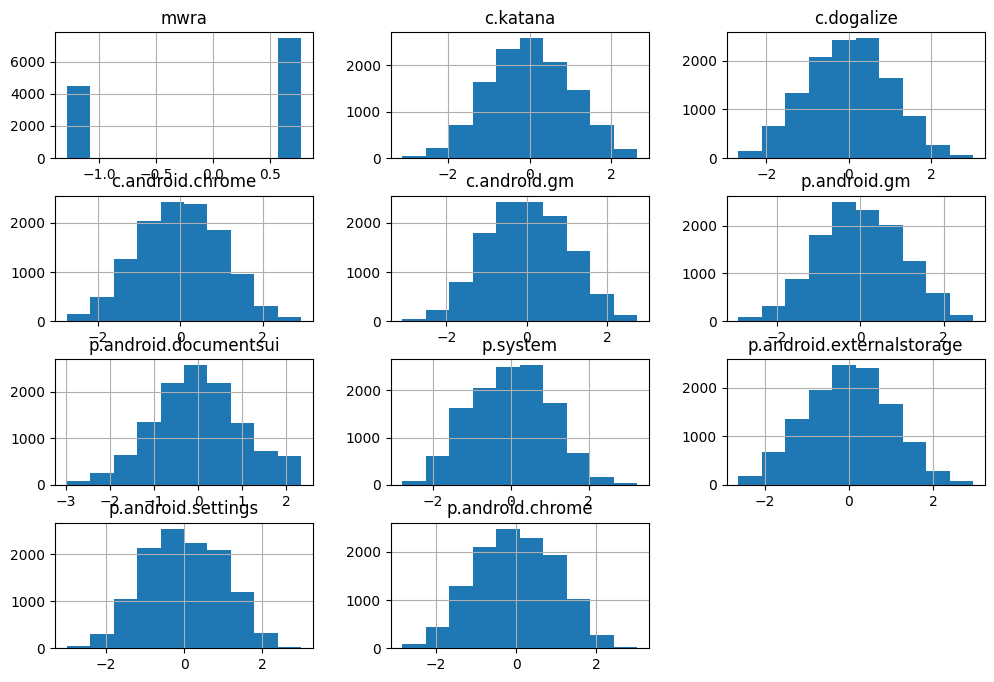

In [58]:
train_df_power_transformed_df.hist(column=train_df_power_transformed_df.columns[1:],figsize=(12,8))

##### Quantile Transformation

In [59]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal')  
train_df_quantile_transformed = quantile_transformer.fit_transform(train_df)

train_df_quantile_transformed_df = pd.DataFrame(train_df_quantile_transformed, columns=train_df.columns)

In [60]:
print("Original Data Description:")
print(train_df.describe())

print("Transformed Data Description:")
print(train_df_quantile_transformed_df.describe())

Original Data Description:
               imei          mwra      c.katana    c.dogalize  \
count  11953.000000  11953.000000  11953.000000  11953.000000   
mean       0.000601     -0.002517      0.000040      0.003430   
std        1.000493      1.000691      0.999334      0.998844   
min       -1.058112     -1.292364     -2.853450     -2.825319   
25%       -0.906636     -1.292364     -0.730729     -0.705388   
50%       -0.086906      0.773776     -0.059068      0.045774   
75%        1.427854      0.773776      0.702556      0.716147   
max        1.427854      0.773776      2.839525      2.837437   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11953.000000  11953.000000  11953.000000           11953.000000   
mean          -0.001366      0.003200      0.002295               0.001057   
std            1.002742      0.998856      0.999365               1.000160   
min           -2.844396     -2.901849     -2.803562              -2.647981 

array([[<Axes: title={'center': 'mwra'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>],
       [<Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.chrome'}>, <Axes: >]],
      dtype=object)

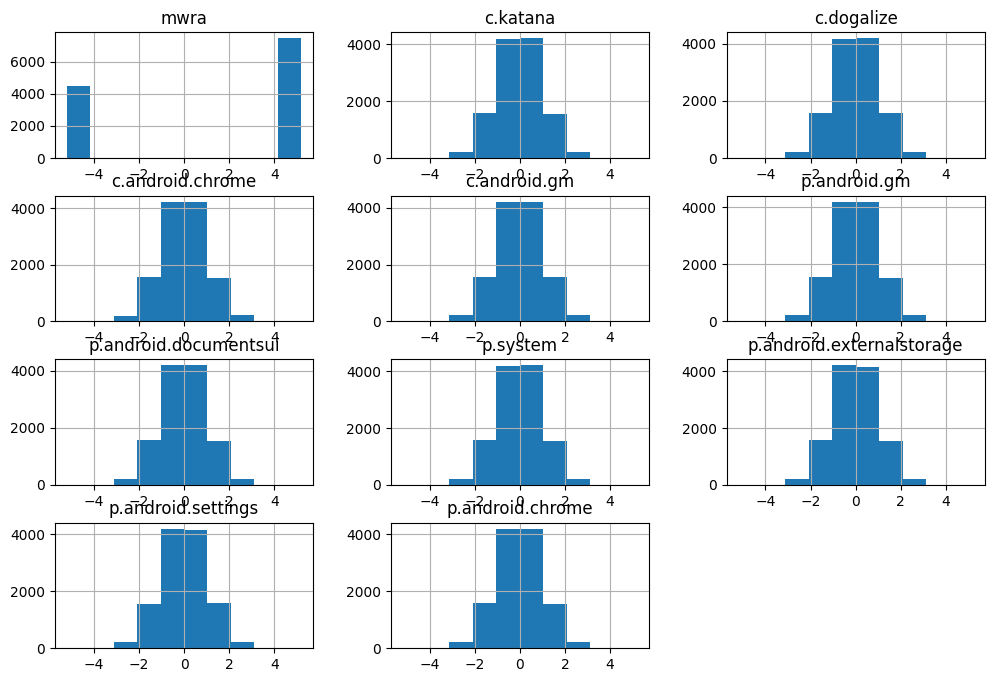

In [69]:
train_df_standard_scaled_shifted.hist(column=train_df_standard_scaled_shifted.columns.drop(["mwra","imei"]), figsize=(12, 8))

#### Scaling

##### Standard Scaling

In [61]:
scaler_standard = StandardScaler()
train_df_standard_scaled = scaler_standard.fit_transform(train_df)

# Shift the data to make all values non-negative
train_df_standard_scaled_shifted = train_df_standard_scaled - np.min(train_df_standard_scaled)

In [62]:
train_df_standard_scaled_shifted = pd.DataFrame(train_df_standard_scaled_shifted, columns=train_df.columns)

print(train_df.describe())
print("\nStardard Scaled")
print(train_df_standard_scaled_shifted.describe())

               imei          mwra      c.katana    c.dogalize  \
count  11953.000000  11953.000000  11953.000000  11953.000000   
mean       0.000601     -0.002517      0.000040      0.003430   
std        1.000493      1.000691      0.999334      0.998844   
min       -1.058112     -1.292364     -2.853450     -2.825319   
25%       -0.906636     -1.292364     -0.730729     -0.705388   
50%       -0.086906      0.773776     -0.059068      0.045774   
75%        1.427854      0.773776      0.702556      0.716147   
max        1.427854      0.773776      2.839525      2.837437   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11953.000000  11953.000000  11953.000000           11953.000000   
mean          -0.001366      0.003200      0.002295               0.001057   
std            1.002742      0.998856      0.999365               1.000160   
min           -2.844396     -2.901849     -2.803562              -2.647981   
25%           -0.711852 

array([[<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.android.chrome'}>, <Axes: >, <Axes: >]],
      dtype=object)

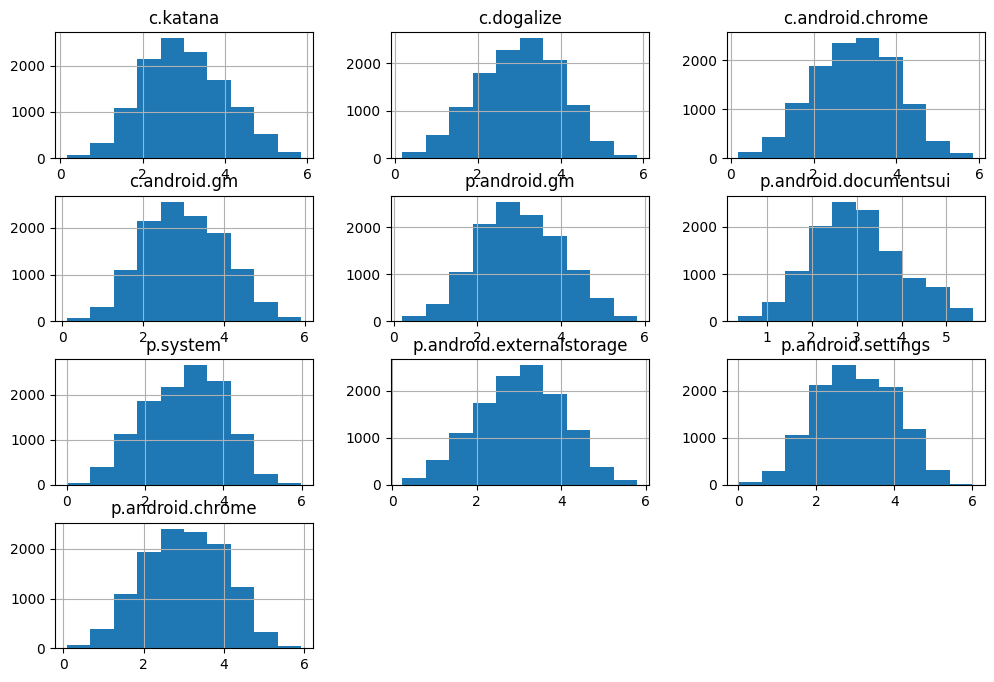

In [76]:
train_df_standard_scaled_shifted.hist(column=train_df_standard_scaled_shifted.columns.drop(["mwra","imei"]), figsize=(12, 8))

##### Min-Max Scaling

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler(feature_range=(0,5))
train_df_minmax = scaler_minmax.fit_transform(train_df)


In [65]:
train_df_minmax = pd.DataFrame(train_df_minmax, columns=train_df.columns)

print(train_df.describe())
print("\nMin-Max Scaled")
print(train_df_minmax.describe())

               imei          mwra      c.katana    c.dogalize  \
count  11953.000000  11953.000000  11953.000000  11953.000000   
mean       0.000601     -0.002517      0.000040      0.003430   
std        1.000493      1.000691      0.999334      0.998844   
min       -1.058112     -1.292364     -2.853450     -2.825319   
25%       -0.906636     -1.292364     -0.730729     -0.705388   
50%       -0.086906      0.773776     -0.059068      0.045774   
75%        1.427854      0.773776      0.702556      0.716147   
max        1.427854      0.773776      2.839525      2.837437   

       c.android.chrome  c.android.gm  p.android.gm  p.android.documentsui  \
count      11953.000000  11953.000000  11953.000000           11953.000000   
mean          -0.001366      0.003200      0.002295               0.001057   
std            1.002742      0.998856      0.999365               1.000160   
min           -2.844396     -2.901849     -2.803562              -2.647981   
25%           -0.711852 

array([[<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.android.chrome'}>, <Axes: >, <Axes: >]],
      dtype=object)

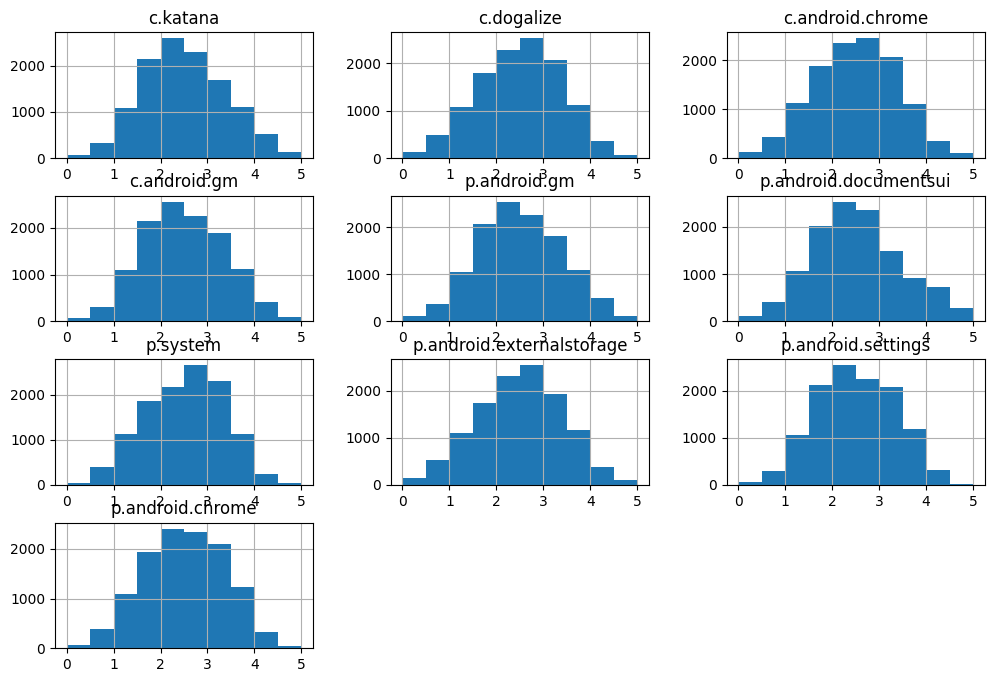

In [75]:
train_df_minmax.hist(column=train_df_minmax.columns.drop(["mwra","imei"]), figsize=(12, 8))

## 2.2 Výber atribútov pre strojové učenie

### A/C - Zisťujeme, ktoré atribúty sú pre ML informatívne k predikovanej premennej + zdôvodnenie

#### RFE - je iteratívna metóda výberu atribútov, ktorá postupne odstraňuje najmenej dôležité atribúty na základe ich prínosu (ich vplyv na model) pre model. Vybrali sme ju, pretože umožňuje identifikovať atribúty, ktoré majú najsilnejší vplyv na predikciu

In [66]:
def get_top_rfe(X, y):

    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=4, step=1)
    selector.fit(X, y)

    features = X.columns[selector.support_].tolist()
    return features

X = train_df.drop(columns=['mwra'])
y = train_df['mwra']

features1 = get_top_rfe(X, y)
print(features1)

['c.katana', 'c.android.chrome', 'c.android.gm', 'p.android.gm']


#### Korelačná analýza - základná metóda, pomocou ktorej sme identifikovali lineárne vzťahy medzi atribútmi a mwra. Potrebná na zistenie, ktoré atribúty sú silno lineárne prepojené s mwra. Vybrali sme si ju kôli jednoduchosti a vhodnosti pre náš model.

In [67]:
def get_top_correlations(the_df):
    numerical_columns = the_df.select_dtypes(include=[np.number])
    correlation_matrix = numerical_columns.corr()
    
    target_correlations = correlation_matrix["mwra"].drop("mwra")
    features = target_correlations.abs().sort_values(ascending=False).head(4)
    
    return features.index.tolist()

features2 = get_top_correlations(train_df)
print(features2)

['c.katana', 'c.android.chrome', 'p.android.gm', 'p.android.documentsui']


#### Mutual info - použitá na meranie množstva informácií, ktoré jeden atribút poskytuje o mrwa. Použili sme ju aj preto, pretože zachytáva aj nelineárne vzťahy medzi premennými, čiže veľmi jedinečné informácie, ktoré niesú lineárne závislé

In [68]:
def get_top_mutual_info(X, y):
    selector = mutual_info_regression(X, y)
    scores = pd.Series(selector, index=X.columns)
    top_features = scores.nlargest(4)
    return top_features.index.tolist()

X = train_df.drop('mwra', axis=1)
y = train_df['mwra']

features3 = get_top_mutual_info(X, y)
print(features3)


['c.katana', 'p.android.gm', 'c.android.chrome', 'p.android.documentsui']


### B/C - zoradenie atribútov + zdôvodnenie

#### Na základe analýzy sme identifikovali najrelevantnejšie atribúty ovplyvňujúce mwra:
1. c.katana
2. c.android.chrome
3. p.android.gm
#### usporiadali sme tieto atribúty v takomto poradí a to na základe výsledkov z predošlích testov, keďže RFE podľa modelu SVR s lineárnym jadromnajlepšie predpovedá tieto atribúty:
['c.katana', 'c.android.chrome', 'c.android.gm', 'p.android.gm']
#### podobne predpovedala aj korelačná závislosť, no rozdiel bol len v jednom atribúte,
['c.katana', 'c.android.chrome', 'p.android.gm', 'p.system']
#### pri mutual information, ktorá sa zameriava na to, koľko informáacií poskytuje každý atribút o mrwa, zistili sme, že najvplyvňejšie atribúty sú:
['c.katana', 'c.android.chrome', 'p.android.gm', 'p.android.settings']